In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
!kaggle datasets download -d ishantripathi93/plant-disease-dataset-iot

 99% 403M/406M [00:04<00:00, 113MB/s]
100% 406M/406M [00:04<00:00, 95.2MB/s]


In [6]:
!unzip /content/plant-disease-dataset-iot.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798.JPG  
  inflating: plantvillage dataset/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915.JPG  
  inflating: plantvillage dataset/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397.JPG  
  inflating: plantvillage dataset/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479.JPG  
  inflating: plantvillage dataset/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144.JPG  
  inflating: plantvillage dataset/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727.JPG  
  inflating: plantvillage dataset/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e849af6-2a4c

In [7]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os
data='/content/plantvillage dataset/color'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)

    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)

            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

In [9]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

Found 21305 validated image filenames belonging to 19 classes.
Found 2663 validated image filenames belonging to 19 classes.
Found 2664 validated image filenames belonging to 19 classes.


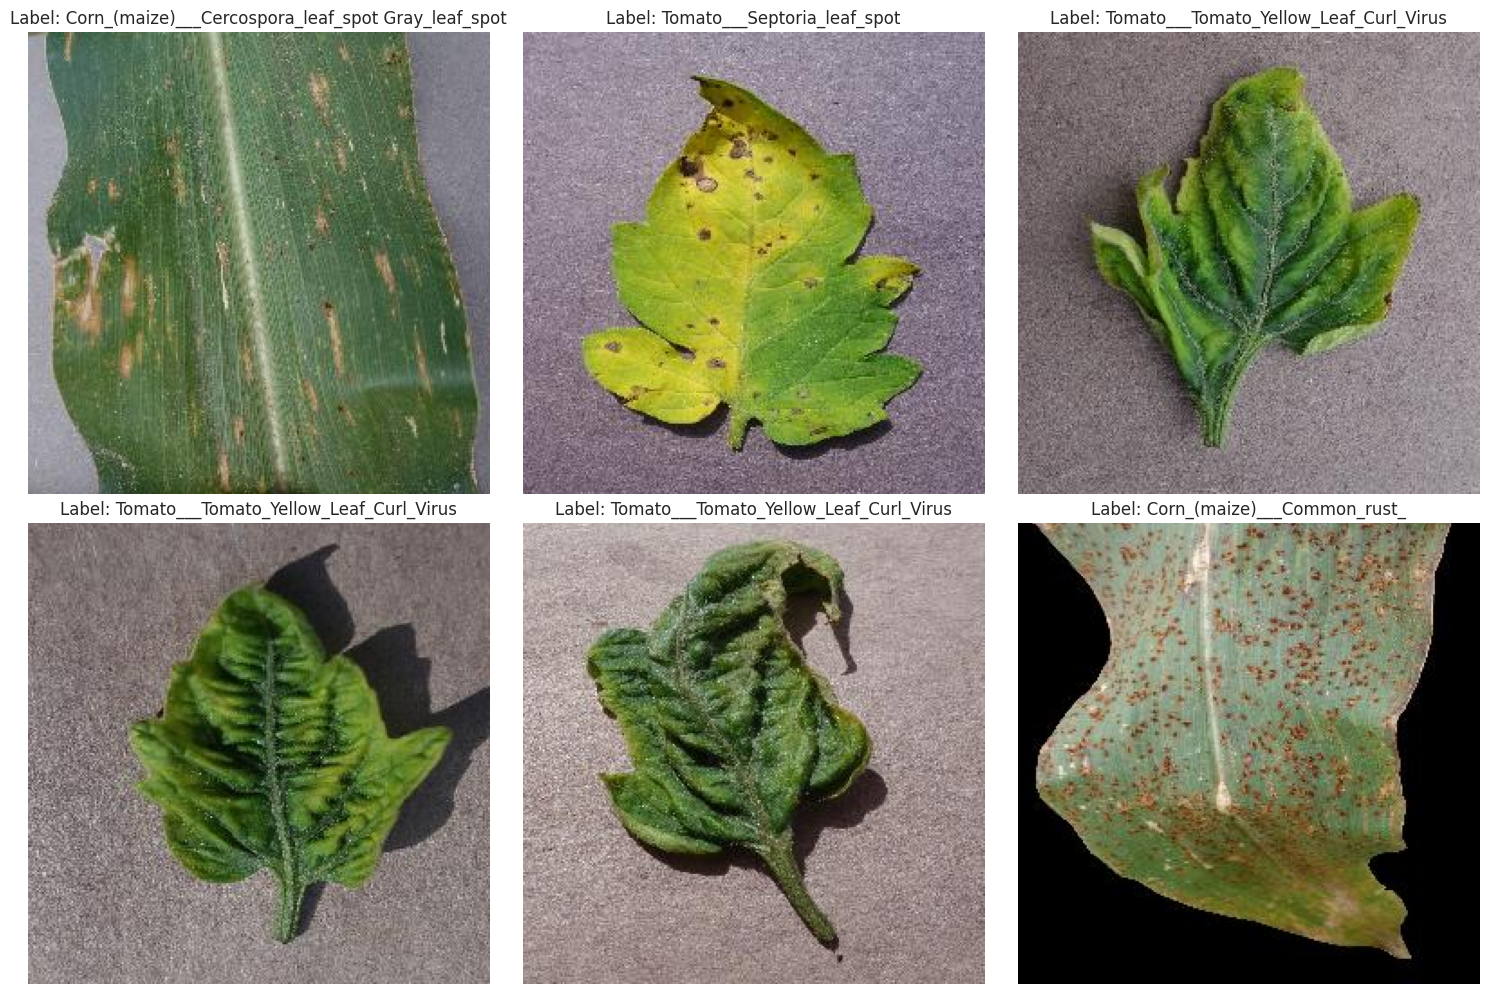

In [11]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']

        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

In [12]:
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (224,224,3) ,
                                                     pooling = 'max' )

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(19 , activation= 'softmax' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])


83683744/83683744 [==============================] - 1s 0us/step


In [13]:
history = model.fit(
    x= train_generator ,
    validation_data= valid_generator ,
    epochs= 5 , verbose = 1 ,
    validation_steps= None, shuffle= False
   )

Epoch 1/5
 29/666 [>.............................] - ETA: 4:42:50 - loss: 1.9524 - accuracy: 0.5420

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.save('IOT.h5')

In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


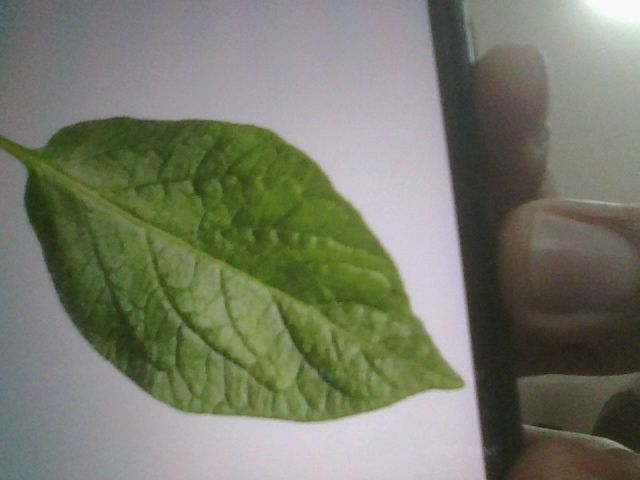

In [19]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(err)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import image

# Load your trained model
model = load_model('/content/IOT.h5')
img='/content/photo.jpg'

# Define the function to process the image
def process_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to predict disease
def predict_disease(img_path):
    processed_img = process_image(img_path)
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class[0]

op=['Potato___Early_blight', 'Tomato___healthy',
 'Corn_(maize)___Northern_Leaf_Blight', 'Pepper,_bell___healthy',
 'Tomato___Septoria_leaf_spot' ,'Pepper,_bell___Bacterial_spot'
 'Potato___healthy', 'Corn_(maize)___healthy' ,'Tomato___Early_blight',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot',
 'Potato___Late_blight', 'Corn_(maize)___Common_rust_' ,'Tomato___Leaf_Mold',
 'Tomato___Spider_mites Two-spotted_spider_mite']
pred=predict_disease(img)
class_index = np.argmax(pred)
class_label = op[class_index]
print(class_label)